In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/scores/scores.csv


In [2]:
data = pd.read_csv('../input/scores/scores.csv')
data.head()

,Python,Sql,ML,Tableau,Excel,Student Placed
0,0.80,0.57,0.63,0.50,0.34,Yes
1,0.81,0.90,0.62,0.71,0.92,No
2,0.49,0.69,0.62,0.64,0.41,No
3,0.40,0.94,0.60,0.26,0.47,No
4,0.31,0.87,1.00,0.23,0.99,No


In [3]:
data.describe()

,Python,Sql,ML,Tableau,Excel
count,200.000000,200.000000,200.000000,200.000000,200.000000
mean,0.514100,0.495850,0.514350,0.495150,0.474950
std,0.305749,0.290694,0.285211,0.292463,0.281686
min,0.000000,0.010000,0.000000,0.010000,0.000000
25%,0.237500,0.227500,0.267500,0.240000,0.227500
50%,0.545000,0.490000,0.540000,0.500000,0.485000
75%,0.800000,0.740000,0.770000,0.740000,0.702500
max,1.000000,1.000000,1.000000,1.000000,0.990000


Checking if there are any null values

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Python          200 non-null    float64
 1   Sql             200 non-null    float64
 2   ML              200 non-null    float64
 3   Tableau         200 non-null    float64
 4   Excel           200 non-null    float64
 5   Student Placed  200 non-null    object 
dtypes: float64(5), object(1)
memory usage: 9.5+ KB


### rename Student Placement column

In [5]:
df = data.rename(columns={'Student Placed':'student_placed'})
df.head()

,Python,Sql,ML,Tableau,Excel,student_placed
0,0.80,0.57,0.63,0.50,0.34,Yes
1,0.81,0.90,0.62,0.71,0.92,No
2,0.49,0.69,0.62,0.64,0.41,No
3,0.40,0.94,0.60,0.26,0.47,No
4,0.31,0.87,1.00,0.23,0.99,No


### Change the yes and no in the Student Placed column to 1 and 0

In [6]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['student_placed'] = le.fit_transform(df['student_placed'])

No NaN values so I can continue without imputing

1    116
0     84
Name: student_placed, dtype: int64

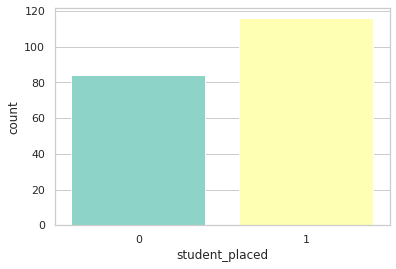

In [7]:
sns.set_theme(style="whitegrid")
sns.countplot(x = df['student_placed'], palette="Set3", saturation = 1)
df['student_placed'].value_counts()

<AxesSubplot:>

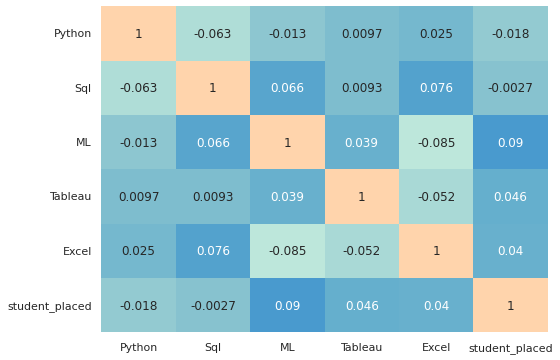

In [8]:
plt.figure(figsize = (8,6))
corr = df.corr()
sns.heatmap(corr,annot = True,cbar = False, cmap = 'icefire')

There looks to be an imbalance in the outcomes

In [9]:
from sklearn.utils import resample

data_major = df[(df['student_placed']==1)]
data_minor = df[(df['student_placed']==0)]
upsample = resample(data_minor,
                    replace = True,
                    n_samples = 116,
                    random_state= 42)
df2 = pd.concat([upsample, data_major])

Now lets check again

0    116
1    116
Name: student_placed, dtype: int64

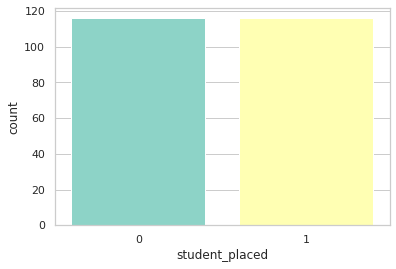

In [10]:
sns.set_theme(style="whitegrid")
sns.countplot(x = df2['student_placed'], palette="Set3", saturation = 1)
df2['student_placed'].value_counts()

<Figure size 720x720 with 0 Axes>

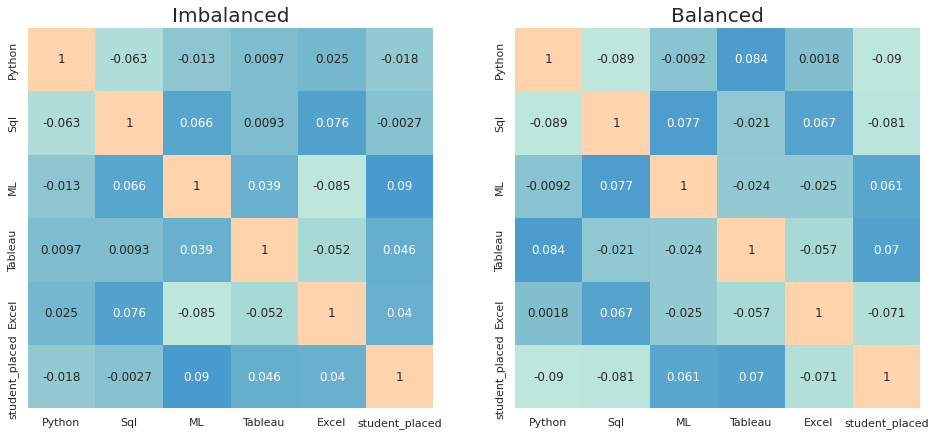

In [11]:
plt.figure(figsize = (10,10))
corr2 = df2.corr()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,7))
ax1 = sns.heatmap(corr,annot=True, cbar = False, cmap = 'icefire', ax=ax[0])
ax2 = sns.heatmap(corr2,annot=True, cbar = False, cmap = 'icefire', ax=ax[1])
ax1.set_title('Imbalanced', fontsize=20)
ax2.set_title('Balanced', fontsize=20)
fig.show()

### Split the data

In [12]:
from sklearn.model_selection import train_test_split

X = df2.drop('student_placed', axis=1)
y = df2['student_placed']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## Impliment Random Forest

In [13]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 1000, max_depth=4, random_state=0)

rf_model = rf.fit(X_train, y_train)
rf_predict = rf_model.predict(X_test)


print("Accuracy on training is:{:.3f}".format(rf_model.score(X_train, y_train)))
print("Accuracy on test is:{:.3f}".format(rf_model.score(X_test, y_test)))

Accuracy on training is:0.879
Accuracy on test is:0.638


These are not great results, so I will see if Gradient Boosting yields better results.

## Gradient Boosting w/ sklearn

In [14]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(learning_rate=.03, n_estimators=110, random_state=0)

gbc_model = gbc.fit(X_train, y_train)
gbc_predict = gbc.predict(X_test)
print("Accuracy on training is:{:.3f}".format(gbc_model.score(X_train, y_train)))
print("Accuracy on test is:{:.3f}".format(gbc_model.score(X_test, y_test)))

Accuracy on training is:0.931
Accuracy on test is:0.759


This result is alright but not great, so I will see if xgboost will yield a better result

## Gradient Boosting w/ xgboost

In [15]:
import xgboost as xgb

train = xgb.DMatrix(X_train, label=y_train)
test = xgb.DMatrix(X_test, label=y_test)

params = {
    'max_depth':6,
    'eta':0.1,
    'objective':'multi:softmax',
    'num_class':2
    }
epochs = 10

In [16]:
xgb_train = xgb.train(params, test, epochs)
xgb_predict = xgb_train.predict(test)
print(xgb_predict)

[1. 0. 0. 1. 0. 1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1.
 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0.
 1. 0. 1. 0. 1. 0. 0. 0. 1. 1.]


## Conclusions

In [17]:
from sklearn.metrics import accuracy_score

print('Random Forest accuracy is: {:.3f}'.format(accuracy_score(y_test, rf_predict)))
print()
print('Gradient Boost accuracy is: {:.3f}'.format(accuracy_score(y_test, gbc_predict)))
print()
print('xgboost accuracy is: {:.3f}'.format(accuracy_score(y_test, xgb_predict)))

Random Forest accuracy is: 0.638

Gradient Boost accuracy is: 0.759

xgboost accuracy is: 1.000
